In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import pmdarima as pm

from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('./data/ghana_gdp.csv',index_col='year',parse_dates=['year'])

data.head(3)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


## Статистические модели прогнозирования. Практика
### План работы (перечень последовательно решаемых задач):
1. Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.
2. Постройте модель скользящего среднего, проанализируйте результат. Для построения ***MA*** используйте метод `rolling`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
> Пример: `train_df.spx.rolling(window=2).mean()`.

3. Оцените стационарность временного ряда и примите решение о выборе модели ***ARMA/ARIMA***. Выберите парамeтры ***p*** и ***q*** по коррелограммам ***ACF*** и ***PACF***. Также постройте модель с параметрами, ближайшими к ***p*** и ***q***, и сравните коэффициент ***AIC*** или подберите наилучшие параметры с помощью ***pmdarima***, как в скринкасте.
4. Постройте модель с наилучшими параметрами и выполните предсказание на три года.
5. Отобразите результат графически.
6. Сделайте выводы.

<span style="color: gray">1. Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.<span>

In [3]:
train = data.iloc[:-3].copy()
test = data.iloc[-3:].copy()

<span style="color: gray">2. Постройте модель скользящего среднего, проанализируйте результат.<span>

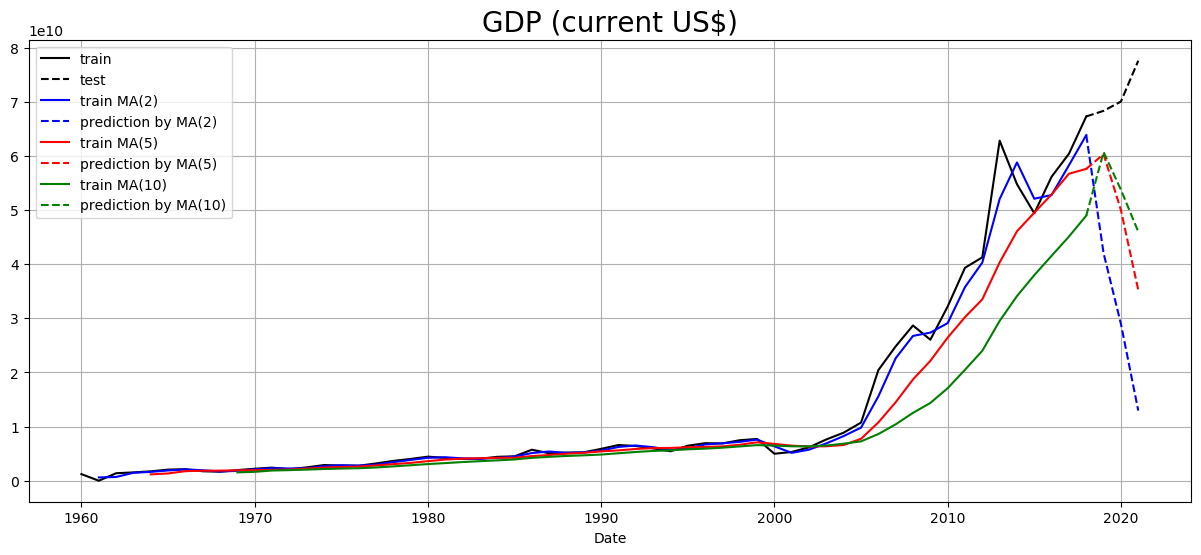

In [4]:
# Определим параметры figure
plt.figure(figsize=(15,6))
plt.title('GDP (current US$)', size = 20)
plt.xlabel('Date')
plt.grid(True)
# Отрисуем train
plt.plot(train,color='black',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='black',linestyle='--')
# Определим параметры для построения и отрисовки MA 
windows = [2,5,10]
colors = ['blue','red','green']
start,end = test.index[0], test.index[-1]
# Отрисуем MA на train и прогноз MA на test
for window,color in zip(windows,colors):
    row = train.rolling(window=window,).mean()
    plt.plot(row,color=color,linestyle='-')
    
    ma = ARIMA(train,order=(0, 0, window),freq='AS')
    ma_mod = ma.fit()    
    pred_test = pd.DataFrame(ma_mod.predict(start,end))
    pred_test.columns = ['GDP (current US$)']
    plt.plot(row.iloc[[-1]].append(pred_test),color=color,linestyle='--')    

legends = ['train', 'test'] + \
[str(xx) + str(x) + ')' for x in windows for xx in ['train MA(','prediction by MA(']] 
plt.legend(legends);

Как видим модель скользящего среднего не справляется с прогнозированием нашего нестационарного (как мы сильно подозреваем, глядя на график, и как мы чуть позже убедимся, воспользовавшись тестом Дики-Фуллера) ряда. Прричем фиаско тем сильнее, чем короче окно скользящего среднего.

<span style="color: gray">3. Оцените стационарность временного ряда и примите решение о выборе модели **ARMA/ARIMA**. Выберите парамeтры **p** и **q** по коррелограммам **ACF** и **PACF**. Также постройте модель с параметрами, ближайшими к **p** и **q**, и сравните коэффициент **AIC** или подберите наилучшие параметры с помощью `pmdarima`, как в скринкасте.</span>   
   

Оценим стационарность воспользовавшись тестом Дики-Фуллера.

In [5]:
print (f'P-value сставляет {adfuller(train)[1]:.3f}')

P-value сставляет 0.989


P-value многократно превышает самый толерантный уровень знчимости 0.1, так что нулевая гипотеза теста Дики-Фуллера о нестационарнотси ряда остается неотвергнутой. Поэтому наш выбор - **ARIMA**.   
   
Сначала определим для модели параметр **d**.

In [6]:
significance = 0.05
train_diff = train.copy()

for d in range(5):
    if adfuller(train_diff)[1] < significance:
        break
    train_diff = train_diff.diff(periods=1).dropna()
    
print(f'При уровне значимости {significance} параметр d = {d}')

При уровне значимости 0.05 параметр d = 3


Теперь определим параметры **p** и **q** по коррелограммам **ACF** и **PACF**.

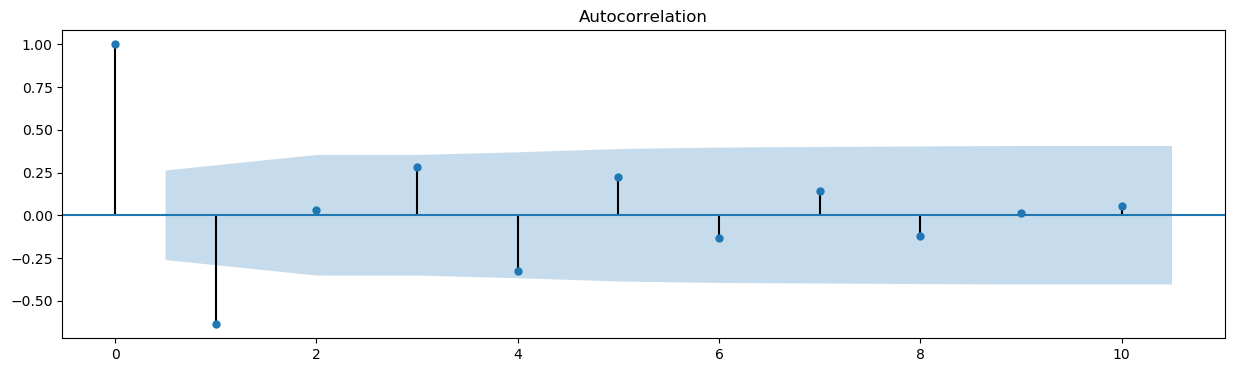

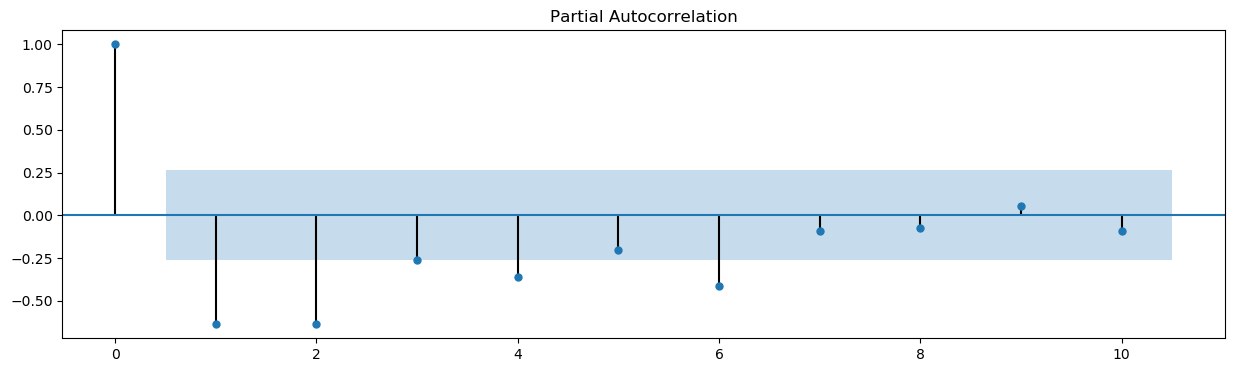

In [7]:
fig_acf = plot_acf(train_diff,lags=10)
fig_acf.set_size_inches(15,4)
# 
fig_pacf = plot_pacf(train_diff,lags=10,method='ywm')
fig_pacf.set_size_inches(15,4)

plt.show()

1. Выберем "вручную" **p** = 1, **q** = 6.   
    
2. В качестве параметров для альтернативных моделей возьмем диапазоны:    
**pp** = range(1,9), **dd** = [3], **qq** = range(9) и перебором выберем модель с наименьшим **AIC**

3. Такие же диапазоны передадим в **auto_arima**

In [8]:
# Выбор праметрв перебором (с условием минимизации AIC)
pp, dd, qq = range(1,9), [3], range(1,9)
aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
    arima_mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = arima_mod.fit()
    aic_series = aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))
    
print('Параметры, выбранные "вручную"\t\tp = {}, d = {}, q = {}'.format(1,3,6))
print('Значение  AIC =  {:.2f}'.format(aic_series[(1,3,6)]))
print('\nПрараметры, определенные перебором:\tp = {}, d = {}, q = {}'.format(*aic_series.idxmin()))
print('Значение  AIC =  {:.2f}'.format(aic_series.min()))

# выбор параметров используя auto_arima
auto_model = pm.auto_arima(train, 
                       start_p=1, d=3, start_q=1,
                       test='adf',
                       max_p=8, max_q=8,
                       trace=False,
                       error_action='ignore', 
                       suppress_warnings=False,
                       stepwise=False)

print('\nПрараметры, определенные auto_arima:\tp = {}, d = {}, q = {}\nЗначение  AIC =  {:.2f}'.
      format(*auto_model.get_params()['order'],auto_model.aic()))

Параметры, выбранные "вручную"		p = 1, d = 3, q = 6
Значение  AIC =  2673.15

Прараметры, определенные перебором:	p = 6, d = 3, q = 4
Значение  AIC =  2626.07

Прараметры, определенные auto_arima:	p = 4, d = 3, q = 1
Значение  AIC =  2647.94


Если исходить из минимизации AIC, то выбранные "вручную" параметры оказались не оптимальными, параметры полученный перебором, естественно оказалсиь наилучшими, а подобранные auto_arima, судя по величине AIC, по результатам находятся где-то посредине. 

<span style="color: gray">4. Постройте модель с наилучшими параметрами и выполните предсказание на три года.<span>    
    
Выполним предсказания используя:   
- модель с параметрами выбранными "вручную";   
- модель с параметрами полученными перебором (с условием минимизации AIC);   
- модель, возвращенную `auto_arima`

In [9]:
# модель с параметрами выбранными "вручную"
manual_p, manual_d, manual_q  = 1, 3, 6
manual_mod = ARIMA(train,order=(manual_p, manual_d, manual_q ),freq='AS')
manual_res = manual_mod.fit()

manual_mod_pred = pd.DataFrame(data=manual_res.forecast(3).values, 
                               index=test.index, 
                               columns=['GDP (current US$)'])
# модель с параметрами полученными перебором (с условием минимизации AIC)
best_p, best_d, best_q = aic_series.idxmin()
best_mod = ARIMA(train,order=(best_p, best_d, best_q ),freq='AS')
best_res = best_mod.fit()

best_mod_pred = pd.DataFrame(data=best_res.forecast(3).values, 
                             index=test.index, 
                             columns=['GDP (current US$)'])
# модель, возвращенная auto_arima
auto_pred = pd.DataFrame(data=auto_model.predict(len(test.index)),
                         index=test.index,
                         columns=['GDP (current US$)'])

<span style="color: gray">5. Отобразите результат графически.<span>

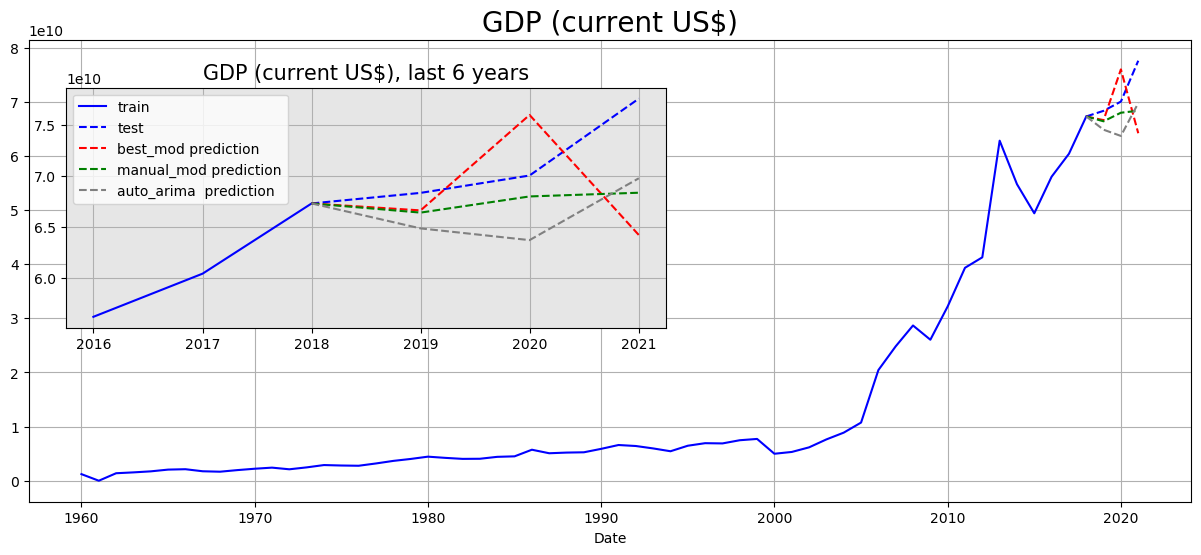

Подбор перебором  RMSE = 8521011124
Ручной подбор     RMSE = 5579404325
Подбор auto_arima RMSE = 6154228986


In [10]:
fig = plt.figure(figsize=(15,6))
plt.title('GDP (current US$)', size = 20)
plt.xlabel('Date')
plt.grid(True)

plt.plot(train,color='blue',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='blue',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(best_mod_pred)),color='red',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(manual_mod_pred)),color='green',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(auto_pred)),color='gray',linestyle='--')

ax_ins = fig.add_axes([0.15, 0.4, 0.4, 0.4])
ax_ins.set_facecolor('0.9')
plt.title('GDP (current US$), last 6 years', size = 15)
plt.grid(True)
plt.plot(train.iloc[-3:],color='blue',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='blue',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(best_mod_pred)),color='red',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(manual_mod_pred)),color='green',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(auto_pred)),color='gray',linestyle='--')

plt.legend(['train','test','best_mod prediction','manual_mod prediction',
            'auto_arima  prediction' ],loc='upper left')
plt.show()

best_mod_rmse = np.sqrt(mean_squared_error(test, best_mod_pred))
manual_mod_rmse = np.sqrt(mean_squared_error(test, manual_mod_pred))
auto_rmse = np.sqrt(mean_squared_error(test, auto_pred))

print(f'Подбор перебором  RMSE = {best_mod_rmse:.0f}')
print(f'Ручной подбор     RMSE = {manual_mod_rmse:.0f}')
print(f'Подбор auto_arima RMSE = {auto_rmse:.0f}')

<span style="color: gray">6. Сделайте выводы.<span>
    
Как видим, **ARIMA** во всех трех случаях отработала много лучше **MA**, что не удивительно, так как наш временной ряд сильно нестационарен и поэтому предназначенная для работы с нестационарными рядами **ARIMA** сильно улучшила качество прогноза.   
    
Что касается оптимального способа подбора параметров, то как мы видим подбор перебором (при том что он обеспечил наименьший **AIC**) дал наибольшую ошибку. Ошибки моделей с параметрами определенными "вручную" и используя **auto_arima** оказались существенно меньше и довольно близки друг к другу.    
    
Вероятно выбор параметров на основе только лишь минимазации **AIC** - не лучший выбор. Впрочем в задании нас интресесует именно **AIC**, поэтому в дальнейшем продолжим определять параметры перебором.

## Интерполяция и сэмплирование. Практика
### План работы (перечень последовательно решаемых задач):

1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода `Series.asfreq()`, передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).
>Подсказка
```df.asfreq(freq='AS')```
2. Проверьте данные на наличие пропущенных значений `(Series.isna().sum())`.
3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`. Воспользуйтесь кодом ниже:
```python 
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
```
4. Для заполнения пропусков выполните интерполяцию с использованием метода `.interpolate()`.
>Подсказка
```df['GDP (current US$)'].interpolate(method='linear')```

5. Проверьте полученный ряд на стационарность, определите параметры модели ***(ARIMA/ARMA)*** и запустите модель.
6. Изменился ли ***AIC*** критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

<span style="color: gray">1. Проверьте данные на наличие пропущенных дат.<span>

In [11]:
print('Количесвто пропущенных дат в данных: {}'.format(train.asfreq(freq='AS').isna().values.sum()))

Количесвто пропущенных дат в данных: 0


<span style="color: gray">2. Проверьте данные на наличие пропущенных значений.<span>

In [12]:
print('Количество пропущенных значений: {}'.format(train.isna().sum().iloc[0]))

Количество пропущенных значений: 0


<span style="color: gray">3. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`.<span>

In [13]:
print('Количество нулевых значений: {}'.format((train['GDP (current US$)'] == 0).sum()))

Количество нулевых значений: 1


Поскольку присутствует нулевое занчение, заменим его на `NaN`

In [14]:
train[train['GDP (current US$)'] == 0] = np.NaN

<span style="color: gray">4. Для заполнения пропусков выполните интерполяцию<span>

In [15]:
train['GDP (current US$)'].interpolate(method='linear',inplace=True)
data.iloc[:-3] = train.copy() # учтем результаты интерполяции и в исходном ряду data

<span style="color: gray">5. Проверьте полученный ряд на стационарность, определите параметры модели ***(ARIMA/ARMA)*** и запустите модель.<span>

In [16]:
print (f'P-value сставляет {adfuller(train)[1]:.3f}')

P-value сставляет 0.992


P-value многократно превышает даже 0.1, что не дает возможности отвергнуть нулевую гипотезу теста Дики-Фуллера, а значит мы будем считать ряд нестаионарным (отметим, что после замены нулевого значения результатом интерполяции p-value немного уменьшился, т.е. нулевое значение привносило в ряд дополнительную нестационарность).

Сначала определим для нестационарного ряда порядок дифференцирования **d**

In [17]:
significance = 0.05
train_diff = train.copy()

for d in range(10):
    if adfuller(train_diff)[1] < significance:
        break
    train_diff = train_diff.diff(periods=1).dropna()
    
print(f'При уровне значимости {significance} параметр d = {d}')

При уровне значимости 0.05 параметр d = 3


Теперь определим **p** и **q** -  порядок авторегрессионной модели и модели скользящего среднего соответсвенно. Для этого испльзуем коррелограммы ACF и PACF.

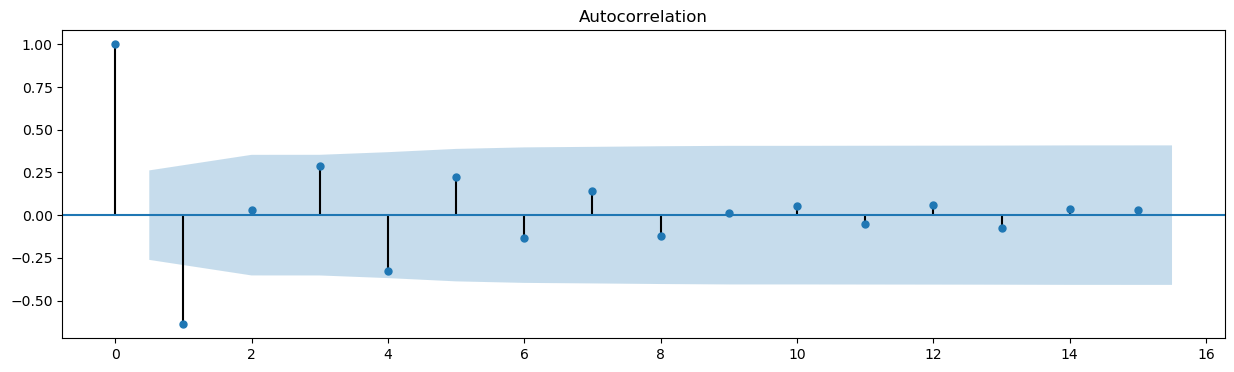

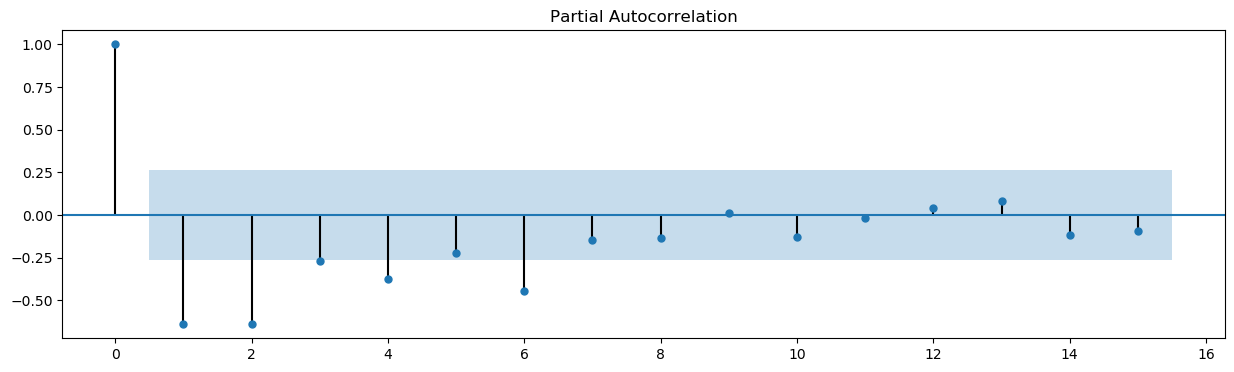

In [18]:
fig_acf = plot_acf(train_diff,lags=15)
fig_acf.set_size_inches(15,4)

fig_pacf = plot_pacf(train_diff,lags=15,method='ywm')
fig_pacf.set_size_inches(15,4)

plt.show()

Картина практически не изменилась по сравнению с данными без обработки пропусков/нулевых значений. Попробум подобрать оптимальные параметры перебором. 

In [19]:
pp, dd, qq = range(1,8), range(0,5), range(1,9)
inter_aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
    arima_mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = arima_mod.fit()
    inter_aic_series = inter_aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))

print('Оптимальные параметры в рассмотренном диапазоне p={} d={} q={}'
      .format(*inter_aic_series.idxmin()))

Оптимальные параметры в рассмотренном диапазоне p=7 d=4 q=5


<span style="color: gray">6. Изменился ли ***AIC*** критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.<span>

In [20]:
print('После обработки пропусков минимальное значение AIC = {:.3f} '.format(inter_aic_series.min()))
print('Без обработки пропусков минимальное значение AIC = {:.3f} '.format(aic_series.min()))

После обработки пропусков минимальное значение AIC = 2588.427 
Без обработки пропусков минимальное значение AIC = 2626.067 


После обработки значение AIC совсем немного, но уменьшилось. Обработка пропусков/нулевых значений устраняет выброс и позволяет чуть улучшить качество модели.

## Валидация временных рядов
### Задание 8.3

![](https://lms.skillfactory.ru/assets/courseware/v1/8016a5615b36084c9633c70a9648f8b3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md13_8_4.png)


1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.    
    
    Пример кода:
```python
tscv = TimeSeriesSplit(...)
```
2. Выведите размеры полученных подвыборок:
```python
train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
```
    
Обратите внимание на отличие в размерах выборок на рисунке с **walk forward validation** и **множественным разбиением**. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [21]:
tscv = TimeSeriesSplit(n_splits=3,max_train_size=len(data)-7)

train_test_groups = tscv.split(data)

for train_index, test_index in train_test_groups:
 print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 17 TEST size: 15
TRAIN size: 32 TEST size: 15
TRAIN size: 47 TEST size: 15


Очевидно, что **TimeSeriesSplit** реализует **множественное разбиение**.

## Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика
### Задания для проекта
1. Посчитайте волатильность для вашего временного ряда.
2. Используйте GARCH-модель для предсказания волатильности.
3. Используйте линейную регрессию для получения прогноза.
4. Визуализируйте полученное предсказание вместе с фактическим значением.
5. Сравните результаты и сделайте выводы.
6. Почему результат модели GARCH получился именно таким?

<span style="color: gray">1. Посчитайте волатильность для вашего временного ряда.<span>

In [22]:
GDP_volat = data['GDP (current US$)'].pct_change().mul(100).abs()

Визуализируем полученную волатильность.

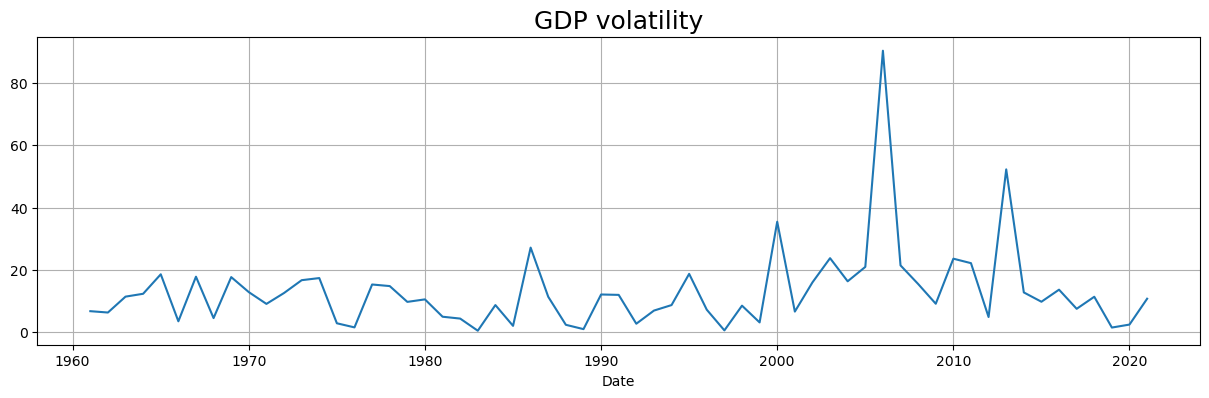

In [23]:
plt.figure(figsize=(15,4))
plt.title('GDP volatility', size = 18)
plt.xlabel('Date')
plt.grid(True)
plt.plot(GDP_volat)
plt.show()

<span style="color: gray">2. Используйте GARCH-модель для предсказания волатильности.<span>
    
Сначала определим обучающую и тетсовую часть данных, проверим стацинарность волатильности.

In [24]:
train_volat = GDP_volat.iloc[:-3]
test_volat = GDP_volat.iloc[-3:]

print (f'P-value составляет {adfuller(GDP_volat[1:])[1]:.4f}')

P-value составляет 0.0000


Гипотезу о нестационарности отвергаем, что позволяет нам воспользоваться **GARCH** (этот подход предполагает, что ряд является стационарным, за исключением изменения дисперсии)

Теперь построим графики автокорреляции и частичной автокорреляции, для того чтобы определить параметры модели p и q. 

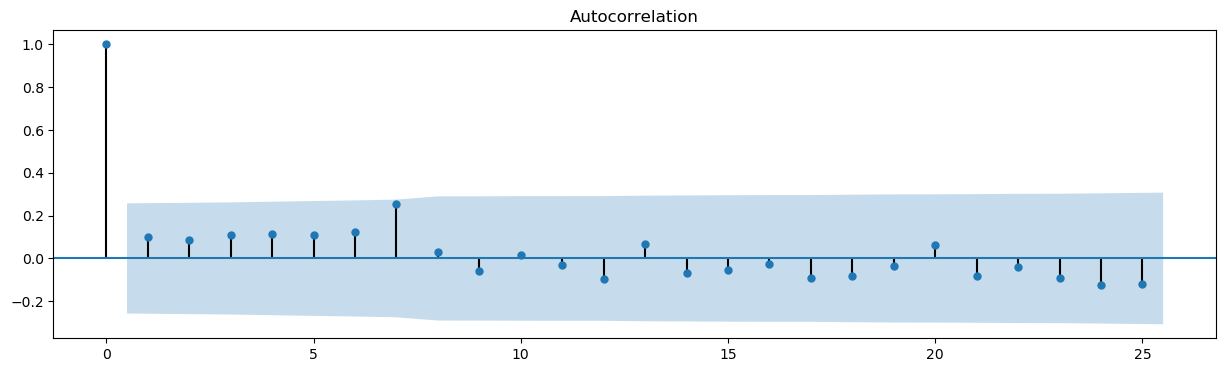

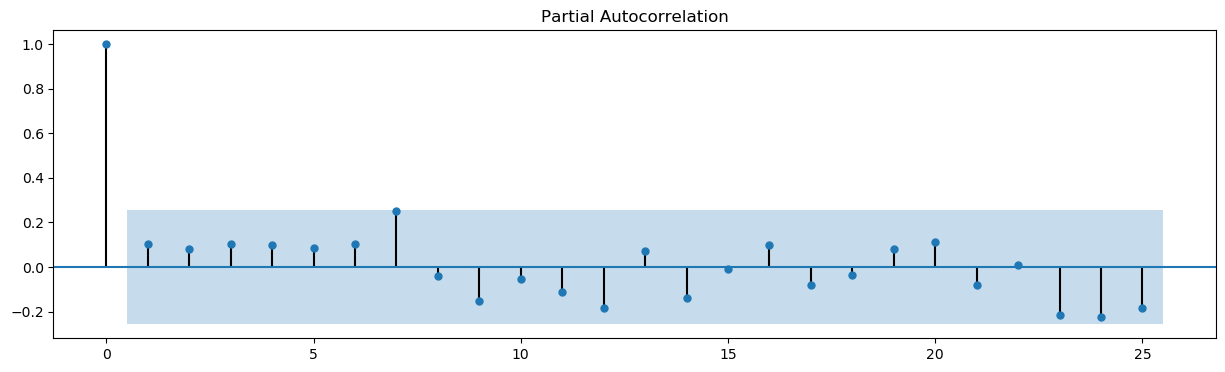

In [25]:
fig_acf = plot_acf(train_volat[1:], lags = 25)
fig_acf.set_size_inches(15,4)

fig_pacf = plot_pacf(train_volat[1:], lags = 25)
fig_pacf.set_size_inches(15,4)

plt.show()

Из графиков определим p = 7 и q = 7. Построим модель и посмотрим на AIC.

In [26]:
garch_mod = arch_model(GDP_volat.iloc[1:], p = 7, q = 7, vol = "GARCH")

garch_result = garch_mod.fit(last_obs = test.index[0], update_freq = 0,disp ='off') # 

garch_pred = garch_result.forecast().variance.loc[test.index]
garch_pred.columns = ['GDP (current US$)']

print(f'при выбранных по acf и pacf параметрах AIC = {garch_result.aic:.0f}')

при выбранных по acf и pacf параметрах AIC = 460


Так же определим параметры методом перебора. Рассмторим диапазон для обоих параметров $[1;10]$

In [27]:
pp, qq = range(1,12), range(1,25)
garch_aic_series = pd.Series()

for p,q in itertools.product(pp, qq, repeat=1):
    select_mod = arch_model(GDP_volat.iloc[1:], p = p, q = q, vol = "GARCH")
    select_result = select_mod.fit(last_obs = test.index[0],disp ='off')
    inter_aic_series = inter_aic_series.append(pd.Series(index = [(p,q)], data=select_result.aic))

print('Оптимальные параметры в рассмотренном диапазоне p={} q={}, при них AIC = {:.2f}'
      .format(*inter_aic_series.idxmin(),inter_aic_series.min()))

Оптимальные параметры в рассмотренном диапазоне p=6 q=1, при них AIC = 446.62


Перебор дал результат лучше, используем для получения прогноза модель с параметрами - результатом перебора

In [28]:
best_p,best_q = inter_aic_series.idxmin()
best_garch_mod = arch_model(GDP_volat.iloc[1:], p=best_p, q=best_q, vol="GARCH")

best_garch_result = best_garch_mod.fit(last_obs=test.index[0], update_freq=0, disp='off') 

best_garch_pred = best_garch_result.forecast().variance.loc[test.index]['h.1']

<span style="color: gray">3. Используйте линейную регрессию для получения прогноза.<span>

In [29]:
X_train = pd.DataFrame(range(len(train_volat.dropna())))
X_test = pd.DataFrame(range(len(train_volat.dropna()),len(train_volat.dropna()) + len(test_volat)))

lr = LinearRegression()
lr.fit(X_train, train_volat.dropna())
lr_predict = lr.predict(X_test)
lr_predict = pd.Series(lr_predict,index = test_volat.index)

<span style="color: gray">4. Визуализируйте полученное предсказание вместе с фактическим значением.<span>

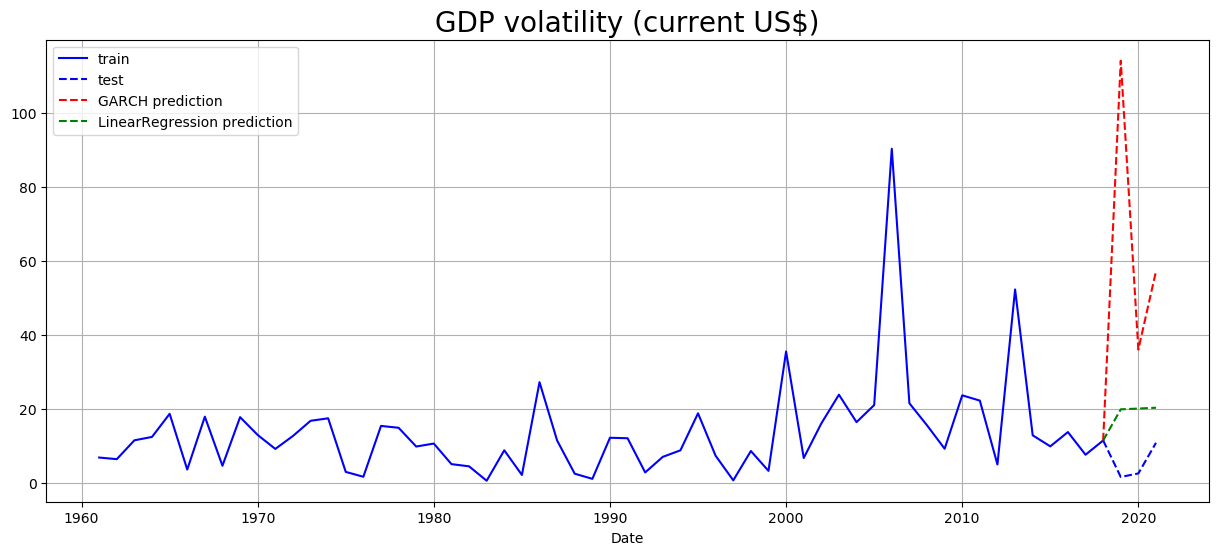

In [30]:
fig = plt.figure(figsize=(15,6))
plt.title('GDP volatility (current US$)', size = 20)
plt.xlabel('Date')
plt.grid(True)

plt.plot(train_volat,color='blue',linestyle='-')
plt.plot(train_volat.iloc[[-1]].append(test_volat),color='blue',linestyle='--')
plt.plot(train_volat.iloc[[-1]].append(best_garch_pred),color='red',linestyle='--')
plt.plot(train_volat.iloc[[-1]].append(lr_predict),color='green',linestyle='--')

plt.legend(['train','test','GARCH prediction','LinearRegression prediction'],loc='upper left')
plt.show()

<span style="color: gray">5. Сравните результаты и сделайте выводы.<span>

In [31]:
garch_rmse = np.sqrt(mean_squared_error(test_volat, best_garch_pred))
lr_rmse = np.sqrt(mean_squared_error(test_volat, lr_predict))

print(f'GARCH RMSE = {garch_rmse}\nLinearRegression RMSE = {lr_rmse}')

GARCH RMSE = 72.86903678220398
LinearRegression RMSE = 15.61368834611179


Как видим обычная линейная регрессия справилась с прогнозом волатильности в данном случае гораздо лучше (RMSE меньше в 4 раза) чем GARCH. На первый взлдяд парадоксальный результат - старая добрая линейная регрессия оказалась лучше модели созданной для решения именно такого рода задач.

<span style="color: gray">6. Почему результат модели GARCH получился именно таким?<span>

Думаю причиной такого результата стала небольшой обьем данных. Авторегрессионная модель, столкнувшись в конце ряда с тремя пиками разделенными лагом в 5-6 лет и общим ростом волатильности, спрогнозировала подобное поведение волатильности и в ближайшем будущем. (при наличии большего обьема данных модель вероятно смогла бы уловить - эти три пика и рост являются тенденцией или случайностью). Регрессия же просто построила прямую, которая на "тестовом" отрезке оказалась ближе к реальным даным.